### Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
# used during development
acidoCEST_ML  = acidoCEST_ML.sample( n = 1_000)

In [5]:
acidoCEST_ML.shape

(1000, 88)

In [6]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,20,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42, criterion = 'mae', n_jobs = -1), param_grid, verbose = 3, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_
    
    
def train_lasso(Xdata, pH_observed):
    print('------------------ LASSO ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter = 5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = 0, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
  
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)

    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train LASSO')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test LASSO')
    
    return estimator.best_estimator_

## 4.2 and 5.6 only

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 4.06 % 
 test  = 3.79 %


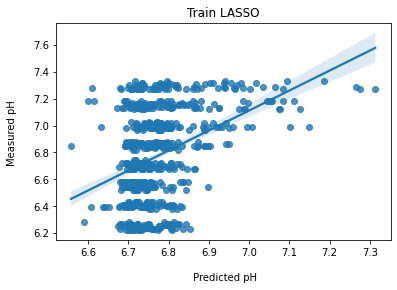

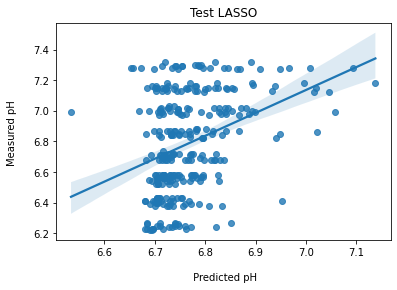

In [7]:
X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_lr = train_lasso(X,Y)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.153 total time=   1.7s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.086 total time=   0.1s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.057 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.152 total time=   0.2s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.084 total time=   0.2s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.060 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.153 total time=   0.4s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.095 total time=   0.4s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.067 total time=   0.4s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.122 total time=   0.1s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.034 total time=  

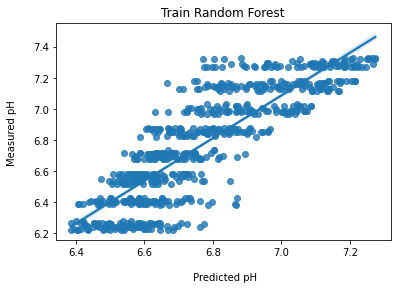

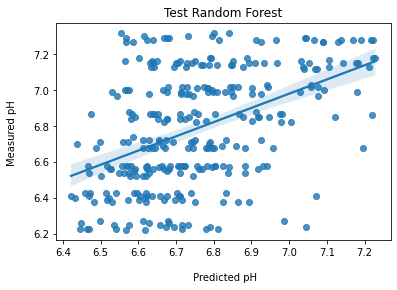

In [8]:
reg_rf = train_RFR(X,Y)

## 4.2 ppm, 5.6 ppm, exp data

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.93 % 
 test  = 3.66 %


Pipeline(steps=[('Scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))])

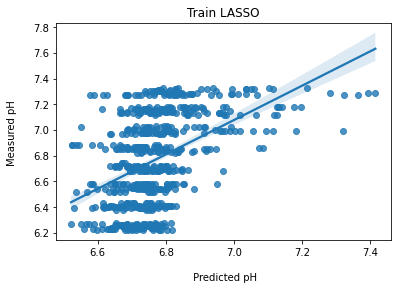

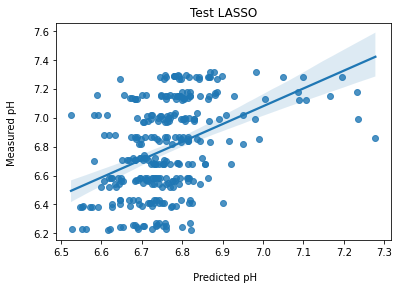

In [9]:
len(['4.2','5.6'] + exper_cols)
c = ['4.2','5.6'] + exper_cols
X = acidoCEST_ML[c]
Y = acidoCEST_ML.pH
train_lasso(X,Y)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.424 total time=   1.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.400 total time=   0.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.442 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.433 total time=   0.3s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.401 total time=   0.3s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.446 total time=   0.3s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.426 total time=   0.7s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.400 total time=   0.7s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.455 total time=   0.7s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.445 total time=   0.2s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.441 total time=  

RandomForestRegressor(criterion='mae', n_estimators=500, n_jobs=-1,
                      random_state=42)

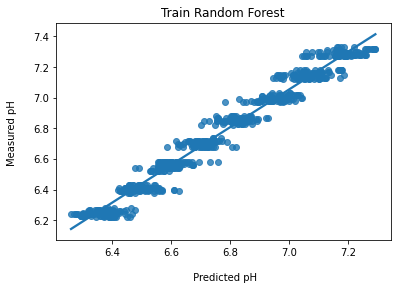

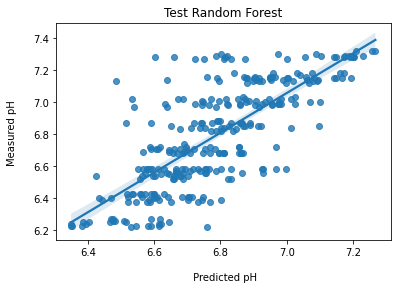

In [10]:
train_RFR(X,Y)

# - Only Zspectra

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.59 % 
 test  = 3.44 %


Pipeline(steps=[('Scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))])

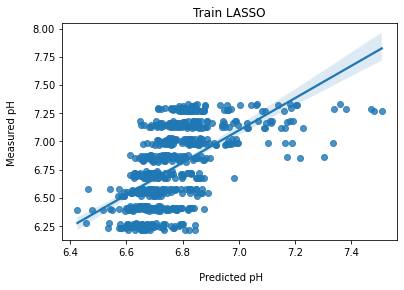

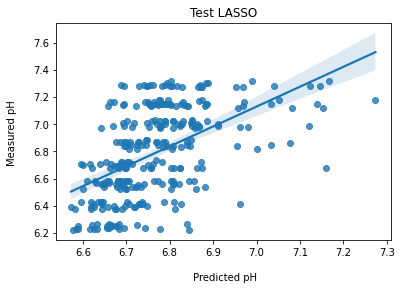

In [11]:
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

train_lasso(Xdata,Ydata)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.303 total time=   2.3s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.355 total time=   1.1s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.333 total time=   1.1s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.303 total time=   2.2s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.368 total time=   2.3s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.330 total time=   2.4s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.300 total time=   5.8s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.380 total time=   6.0s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.330 total time=   5.9s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.306 total time=   1.2s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.346 total time=  

RandomForestRegressor(criterion='mae', max_depth=20, n_estimators=500,
                      n_jobs=-1, random_state=42)

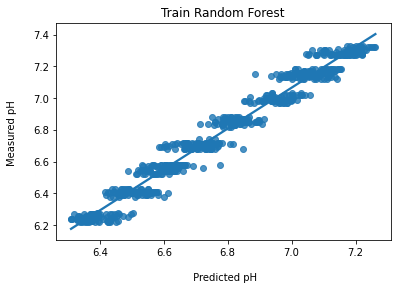

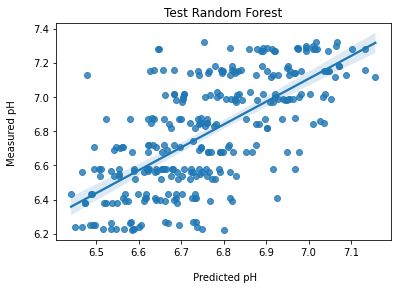

In [12]:
train_RFR(Xdata,Ydata)

# -  Zspectra  + exp data
## selected

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.41 %


Lasso(alpha=0.01, max_iter=5000, random_state=42)

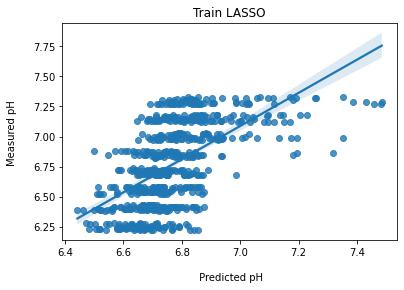

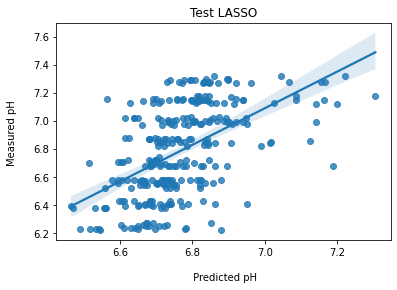

In [13]:
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

lasso = train_lasso(Xdata,Ydata)

lasso['lasso']

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.281 total time=   2.6s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.327 total time=   1.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.385 total time=   1.3s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.288 total time=   2.3s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.325 total time=   2.6s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.390 total time=   2.5s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.298 total time=   6.0s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.316 total time=   6.5s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.405 total time=   6.1s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.288 total time=   1.4s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.334 total time=  

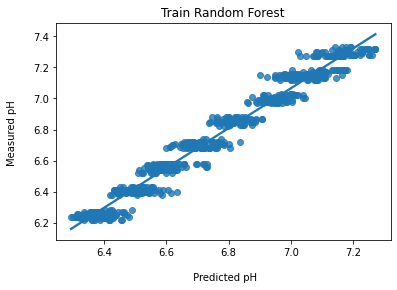

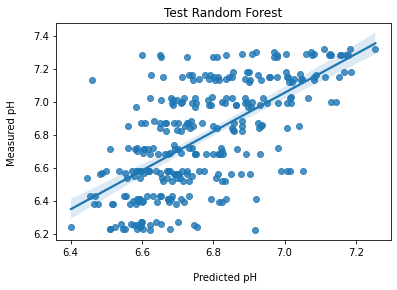

In [14]:
RF    = train_RFR(Xdata,Ydata)

## LASSO COEFF

Text(0, 0.5, 'Value \n')

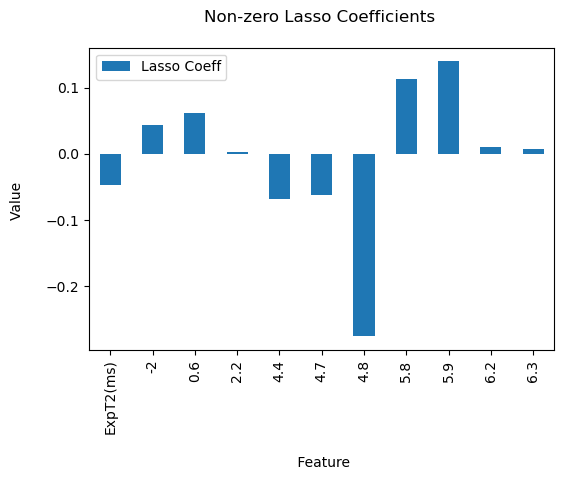

In [15]:
reg_lasso = lasso['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')



In [16]:
list(C[reg_lasso.coef_ != 0].index)

['ExpT2(ms)',
 '-2',
 '0.6',
 '2.2',
 '4.4',
 '4.7',
 '4.8',
 '5.8',
 '5.9',
 '6.2',
 '6.3']

## Random Forest, Feature Importance

<AxesSubplot:>

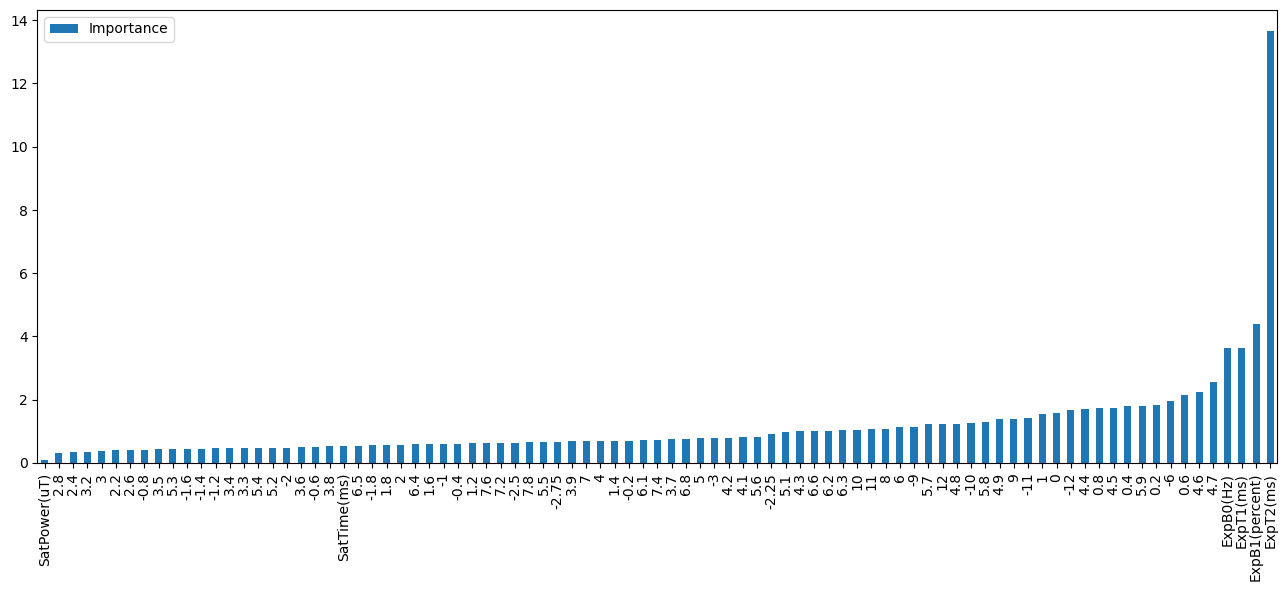

In [17]:
I = pd.DataFrame( 100 * RF.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))

I.sort_values('Importance').plot(kind='bar', ax = ax, rot=90)

## Feature Selection

In [18]:
from sklearn.feature_selection import SelectFromModel

In [19]:
selected_lasso = SelectFromModel( reg_lasso, max_features=20) 
selected_lasso.fit(Xdata, Ydata)
Xdata.columns[selected_lasso.get_support()]

Index(['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)',
       'SatPower(uT)'],
      dtype='object')

In [20]:
selected_RF = SelectFromModel( RF  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]
print(cols)

Index(['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)', '-11', '0',
       '0.2', '0.4', '0.6', '0.8', '1', '4.4', '4.5', '4.6', '4.7', '4.8',
       '4.9', '5.7', '5.8', '5.9'],
      dtype='object')


------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.364 total time=   0.4s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.398 total time=   0.4s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.427 total time=   0.4s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.366 total time=   0.7s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.403 total time=   0.8s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.429 total time=   0.7s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.355 total time=   1.6s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.394 total time=   1.7s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.437 total time=   1.7s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.381 total time=   0.4s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.412 total time=  

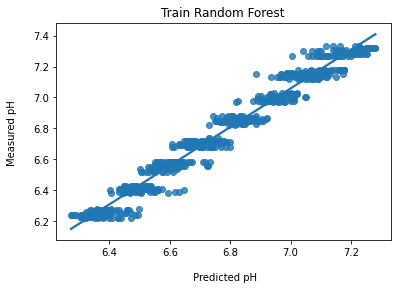

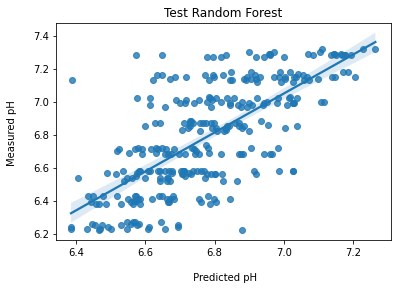

In [21]:
RF_sel    = train_RFR(Xdata[cols],Ydata)

## Tree Vis

In [22]:
n_features = []

for i,tree in enumerate( RF.estimators_):
    ft = list( Xdata.columns[ tree.feature_importances_ != 0  ]  )
    n = len(Xdata.columns[ tree.feature_importances_ != 0  ])
    n_non_CEST = sum(['(' in x for x in ft])
    print(f' tree = {i+1} | {n - n_non_CEST} saturation frequencies | {n_non_CEST} non-CEST | total = {n}')
    n_features.append(n)

 tree = 1 | 79 saturation frequencies | 5 non-CEST | total = 84
 tree = 2 | 77 saturation frequencies | 6 non-CEST | total = 83
 tree = 3 | 77 saturation frequencies | 5 non-CEST | total = 82
 tree = 4 | 78 saturation frequencies | 5 non-CEST | total = 83
 tree = 5 | 75 saturation frequencies | 5 non-CEST | total = 80
 tree = 6 | 73 saturation frequencies | 6 non-CEST | total = 79
 tree = 7 | 79 saturation frequencies | 6 non-CEST | total = 85
 tree = 8 | 75 saturation frequencies | 5 non-CEST | total = 80
 tree = 9 | 78 saturation frequencies | 5 non-CEST | total = 83
 tree = 10 | 78 saturation frequencies | 6 non-CEST | total = 84
 tree = 11 | 79 saturation frequencies | 6 non-CEST | total = 85
 tree = 12 | 78 saturation frequencies | 5 non-CEST | total = 83
 tree = 13 | 80 saturation frequencies | 6 non-CEST | total = 86
 tree = 14 | 76 saturation frequencies | 5 non-CEST | total = 81
 tree = 15 | 79 saturation frequencies | 5 non-CEST | total = 84
 tree = 16 | 78 saturation frequen

In [23]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


idx = np.argmin(n_features)-1
tree= RF.estimators_[idx]

#classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = Xdata.columns,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig(f'../figs/Tree_example_max_depth_04_tree{idx}_regression.png',bbox_inches='tight')

In [24]:
from sklearn.tree import export_text

tree_as_text = export_text( tree
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = list( Xdata.columns  )
                  , show_weights=True )   

In [25]:
print(tree_as_text)

|--- 4.3 <= 0.827
|   |--- 5.8 <= 0.844
|   |   |--- 5 <= 0.760
|   |   |   |--- 6 <= 0.787
|   |   |   |   |--- 5.2 <= 0.667
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- 5.2 >  0.667
|   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- 6 >  0.787
|   |   |   |   |--- 2.2 <= 0.579
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- 2.2 >  0.579
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |--- 5 >  0.760
|   |   |   |--- 2 <= 0.566
|   |   |   |   |--- -1.4 <= 0.806
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- -1.4 >  0.806
|   |   |   |   |   |--- value: [7.130]
|   |   |   |--- 2 >  0.566
|   |   |   |   |--- 8 <= 0.973
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- 8 >  0.973
|   |   |   |   |   |--- truncated branch of depth 2
|   |--- 5.8 >  0.844
|   |   |--- 4.8 <= 0.828
|   |   |   |--- -3 <= 0.873
|   |   |   |   |--- 6.5 <= 0.890
|   |   